# Experiment Tracking

In [43]:
import torch
import pandas as pd
import numpy as np
from torch import nn
import torchvision,torchinfo
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Get going modular codes 

In [44]:
from going_modular.going_modular import data_setup,engine,model_builder,predictions,utils

In [45]:
def set_seed(seed=42):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

In [46]:
set_seed()

## 1 Get data

In [47]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [48]:
import os
import zipfile
from pathlib import Path
import requests
def download_data(source,destination,remove_source=True):
    data_path=Path("Data/")
    image_path=data_path/destination
    if image_path.is_dir():
        print("directory already exist")
    else:
        print(f"Creating Directory")
        image_path.mkdir(parents=True,exist_ok=True)
        target_file=Path(source).name
        with open(data_path/target_file,'wb') as f:
            request=requests.get(source)
            print("Downloaded file from source")
            f.write(request.content)
        with zipfile.ZipFile(data_path/target_file) as zip_ref:
            print("Extracting zip file")
            zip_ref.extractall(image_path)
        if remove_source:
            os.remove(data_path/target_file)
    return image_path
        

downloding file

In [49]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")


directory already exist


## 2 Creating Data Loaders

In [50]:
test_dir=image_path/'test'

train_dir=image_path/'train'
train_dir,test_dir

(WindowsPath('Data/pizza_steak_sushi/train'),
 WindowsPath('Data/pizza_steak_sushi/test'))

In [51]:

# * Transforms
from torchvision import transforms
manual_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
manual_transforms


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [52]:

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=str(train_dir),
    test_dir=str(test_dir),
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26fc86c2f30>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Auto transforms

In [53]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
transforms_auto=weights.transforms()
transforms_auto

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [54]:

#! new data loaders with auto transforms
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(test_dir=test_dir,train_dir=train_dir,transform=transforms_auto,batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26fc86c2840>,
 ['pizza', 'steak', 'sushi'])

## 3 Getting pretrained model freeze base layer

In [55]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT

model=torchvision.models.efficientnet_b0(weights=weights)

Freeze base layers

In [56]:
for params in model.features.parameters():
    params.requires_grad=False

Adjust classifier

In [57]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [58]:
set_seed()
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names))
).to(device)

In [59]:
torchinfo.summary(model=model,input_size=(32,3,224,224),device=device,col_width=20,row_settings=['var_names'],col_names=['input_size',"output_size","trainable","num_params"])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              Partial              --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     False                --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   False                --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   False                (864)
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   False                (64)
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112] 

## 4 train Model

In [60]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [61]:
from typing import Dict,List,Tuple
from tqdm.auto import tqdm
from going_modular.going_modular.engine import train_step, test_step

def train(model: nn.Module, 
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader,epochs,
        loss_fn: nn.Module, 
        optimizer, 
        device ="cpu"):
    results={
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss,test_acc=test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
          # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
# ! cant use tensorboard
    return results

In [62]:
results=train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,epochs=5,device=device,loss_fn=loss_fn,optimizer=optimizer)
results

 20%|██        | 1/5 [00:14<00:57, 14.42s/it]

Epoch: 1 | train_loss: 1.0482 | train_acc: 0.3867 | test_loss: 0.8392 | test_acc: 0.7443


 40%|████      | 2/5 [00:28<00:43, 14.39s/it]

Epoch: 2 | train_loss: 0.9104 | train_acc: 0.6211 | test_loss: 0.7109 | test_acc: 0.8864


 60%|██████    | 3/5 [00:45<00:30, 15.33s/it]

Epoch: 3 | train_loss: 0.7623 | train_acc: 0.7422 | test_loss: 0.6893 | test_acc: 0.8864


 80%|████████  | 4/5 [00:59<00:15, 15.07s/it]

Epoch: 4 | train_loss: 0.7180 | train_acc: 0.7461 | test_loss: 0.6004 | test_acc: 0.8655


100%|██████████| 5/5 [01:14<00:00, 14.97s/it]

Epoch: 5 | train_loss: 0.6185 | train_acc: 0.7812 | test_loss: 0.5975 | test_acc: 0.8968


{'train_loss': [1.0481869205832481,
  0.9103704914450645,
  0.762336291372776,
  0.7180280014872551,
  0.618484154343605],
 'train_acc': [0.38671875, 0.62109375, 0.7421875, 0.74609375, 0.78125],
 'test_loss': [0.8391558527946472,
  0.7108861406644186,
  0.6892503897349039,
  0.6004232366879781,
  0.5974783500035604],
 'test_acc': [0.7443181818181818,
  0.8863636363636364,
  0.8863636363636364,
  0.8655303030303031,
  0.8967803030303031]}

## 5 n 6 skipped dut ot tensorboard

## 7 Setting up a no of experiments

### 7.1 training 1 model for 5 epoch and other for 10 epochs


### 7.2 What experiments are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of test set accuracy (90%+) but doesn't take too long to train/perform inference (make predictions).

We've got plenty of options but how about we keep things simple?

Let's try a combination of:
1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model ([`torchvision.models.efficientnet_b0`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) vs. [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2))
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get: 

| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| ----- | ----- | ----- | ----- |
| 1 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 | 
| 3 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 | 
| 4 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |

Notice how we're slowly scaling things up. 

With each experiment we slowly increase the amount of data, the model size and the length of training.

By the end, experiment 8 will be using double the data, double the model size and double the length of training compared to experiment 1.

> **Note:** I want to be clear that there truly is no limit to amount of experiments you can run. What we've designed here is only a very small subset of options. However, you can't test *everything* so best to try a few things to begin with and then follow the ones which work the best.
>
> And as a reminder, the datasets we're using are a subset of the [Food101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101) (3 classes, pizza, steak, suhsi, instead of 101) and 10% and 20% of the images rather than 100%. If our experiments work, we could start to run more on more data (though this will take longer to compute). You can see how the datasets were created via the [`04_custom_data_creation.ipynb` notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


Download data

In [63]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

directory already exist
Creating Directory
Downloaded file from source
Extracting zip file


In [64]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: Data\pizza_steak_sushi\train
Training directory 20%: Data\pizza_steak_sushi_20_percent\train
Testing directory: Data\pizza_steak_sushi\test


In [69]:
train_dataloader_10_percent,test_dataloader_10_pecent,class_names=data_setup.create_dataloaders(train_dir=train_dir_10_percent,test_dir=test_dir,transform=manual_transforms,num_workers=os.cpu_count(),batch_size=32)
train_dataloader_20_percent,test_dataloader_20_pecent,class_names=data_setup.create_dataloaders(train_dir=train_dir_20_percent,test_dir=test_dir,transform=manual_transforms,num_workers=os.cpu_count(),batch_size=32)

train_dataloader_20_percent,test_dataloader_20_pecent,class_names,train_dataloader_10_percent,test_dataloader_10_pecent,class_names


(<torch.utils.data.dataloader.DataLoader at 0x2702b1fa180>,
 ['pizza', 'steak', 'sushi'],
 ['pizza', 'steak', 'sushi'])

In [70]:
len(train_dataloader_10_percent),len(test_dataloader_10_pecent),len(test_dataloader_20_pecent),len(train_dataloader_20_percent)

(8, 3, 3, 15)

In [67]:
effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)
torchinfo.summary(model=effnetb2,input_size=(32,3,224,224),device=device,col_width=20,row_settings=['var_names'],col_names=['input_size',"output_size","trainable","num_params"])


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\ArnavBhatia/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:30<00:00, 1.21MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           True                 --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     True                 --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   True                 --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   True                 864
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   True                 64
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   Tr

In [71]:
for param in effnetb2.features.parameters():
    param.requires_grad=False

In [72]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [73]:
effnetb2.classifier=nn.Sequential(
  nn.Dropout(p=0.3, inplace=True),
  nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

In [74]:
torchinfo.summary(model=effnetb2,input_size=(32,3,224,224),device=device,col_width=20,row_settings=['var_names'],col_names=['input_size',"output_size","trainable","num_params"])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              Partial              --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     False                --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   False                --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   False                (864)
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   False                (64)
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112] 

Functions to create models

In [77]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [79]:
effnetb0=create_effnetb0()
effnetb2=create_effnetb2()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.


In [80]:
torchinfo.summary(model=effnetb0,input_size=(32,3,224,224),device=device,col_width=20,row_settings=['var_names'],col_names=['input_size',"output_size","trainable","num_params"])


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              Partial              --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     False                --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   False                --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   False                (864)
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   False                (64)
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112] 

### 7.6 Create Experiments

In [83]:
num_epoch=[5,10]
models=["effnetb0","effnetb2"]
train_dataloaders={
    "data_10_percent":train_dataloader_10_percent,
    "data_20_percent":train_dataloader_20_percent
}

In [84]:
%%time
from going_modular.going_modular.utils import save_model
set_seed()
experiment_number=0
for dataloader_name,train_dataloader in train_dataloaders.items():
    for epochs in num_epoch:
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  
            # 1. Load the model
            if model_name=="effnetb0":
                model=create_effnetb0()
            elif model_name=="effnetb2":
                model=create_effnetb2()
            else:
                print("no name give ")
                break
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            # 2. Train the model
            train(model=model, train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn= loss_fn,optimizer=optimizer,epochs= epochs, device=device)
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")




[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.


 20%|██        | 1/5 [00:17<01:08, 17.07s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.8890 | test_acc: 0.5805


 40%|████      | 2/5 [00:32<00:48, 16.08s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8064 | test_acc: 0.6818


 60%|██████    | 3/5 [00:47<00:31, 15.57s/it]

Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7300 | test_acc: 0.8134


 80%|████████  | 4/5 [01:02<00:15, 15.52s/it]

Epoch: 4 | train_loss: 0.7097 | train_acc: 0.7578 | test_loss: 0.6182 | test_acc: 0.9062


100%|██████████| 5/5 [01:19<00:00, 15.84s/it]

Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.6040 | test_acc: 0.8854
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.


 20%|██        | 1/5 [00:15<01:02, 15.65s/it]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.3711 | test_loss: 0.9589 | test_acc: 0.6402


 40%|████      | 2/5 [00:31<00:46, 15.52s/it]

Epoch: 2 | train_loss: 0.9249 | train_acc: 0.6445 | test_loss: 0.8695 | test_acc: 0.7746


 60%|██████    | 3/5 [00:46<00:30, 15.45s/it]

Epoch: 3 | train_loss: 0.8087 | train_acc: 0.7656 | test_loss: 0.7516 | test_acc: 0.8447


 80%|████████  | 4/5 [01:01<00:15, 15.26s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7283 | test_acc: 0.8655


100%|██████████| 5/5 [01:16<00:00, 15.30s/it]


Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7656 | test_loss: 0.7244 | test_acc: 0.8665
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


 10%|█         | 1/10 [00:14<02:12, 14.71s/it]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.8890 | test_acc: 0.5805


 20%|██        | 2/10 [00:29<02:00, 15.03s/it]

Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8064 | test_acc: 0.6818


 30%|███       | 3/10 [00:46<01:49, 15.61s/it]

Epoch: 3 | train_loss: 0.8099 | train_acc: 0.6445 | test_loss: 0.7300 | test_acc: 0.8134


 40%|████      | 4/10 [01:02<01:35, 15.98s/it]

Epoch: 4 | train_loss: 0.7097 | train_acc: 0.7578 | test_loss: 0.6182 | test_acc: 0.9062


 50%|█████     | 5/10 [01:20<01:22, 16.45s/it]

Epoch: 5 | train_loss: 0.5980 | train_acc: 0.9141 | test_loss: 0.6040 | test_acc: 0.8854


 60%|██████    | 6/10 [01:36<01:05, 16.27s/it]

Epoch: 6 | train_loss: 0.5611 | train_acc: 0.8984 | test_loss: 0.6253 | test_acc: 0.8968


 70%|███████   | 7/10 [01:52<00:48, 16.31s/it]

Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5869 | test_acc: 0.8759


 80%|████████  | 8/10 [02:08<00:32, 16.17s/it]

Epoch: 8 | train_loss: 0.4702 | train_acc: 0.9492 | test_loss: 0.5452 | test_acc: 0.8352


 90%|█████████ | 9/10 [02:26<00:16, 16.65s/it]

Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7773 | test_loss: 0.5426 | test_acc: 0.8551


100%|██████████| 10/10 [02:42<00:00, 16.22s/it]

Epoch: 10 | train_loss: 0.4794 | train_acc: 0.8242 | test_loss: 0.5052 | test_acc: 0.8551
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.


 10%|█         | 1/10 [00:16<02:27, 16.42s/it]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.3711 | test_loss: 0.9589 | test_acc: 0.6402


 20%|██        | 2/10 [00:33<02:16, 17.10s/it]

Epoch: 2 | train_loss: 0.9249 | train_acc: 0.6445 | test_loss: 0.8695 | test_acc: 0.7746


 30%|███       | 3/10 [00:51<01:59, 17.07s/it]

Epoch: 3 | train_loss: 0.8087 | train_acc: 0.7656 | test_loss: 0.7516 | test_acc: 0.8447


 40%|████      | 4/10 [01:09<01:44, 17.45s/it]

Epoch: 4 | train_loss: 0.7191 | train_acc: 0.8867 | test_loss: 0.7283 | test_acc: 0.8655


 50%|█████     | 5/10 [01:24<01:24, 16.90s/it]

Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7656 | test_loss: 0.7244 | test_acc: 0.8665


 60%|██████    | 6/10 [01:41<01:06, 16.71s/it]

Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6638 | test_acc: 0.8655


 70%|███████   | 7/10 [01:57<00:49, 16.61s/it]

Epoch: 7 | train_loss: 0.6126 | train_acc: 0.8008 | test_loss: 0.6446 | test_acc: 0.8655


 80%|████████  | 8/10 [02:13<00:32, 16.36s/it]

Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6329 | test_acc: 0.8968


 90%|█████████ | 9/10 [02:30<00:16, 16.41s/it]

Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6399 | test_acc: 0.8456


100%|██████████| 10/10 [02:46<00:00, 16.70s/it]


Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.6201 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.


 20%|██        | 1/5 [00:18<01:14, 18.61s/it]

Epoch: 1 | train_loss: 0.9577 | train_acc: 0.6188 | test_loss: 0.6416 | test_acc: 0.9062


 40%|████      | 2/5 [00:36<00:54, 18.08s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5841 | test_acc: 0.9271


 60%|██████    | 3/5 [00:55<00:36, 18.37s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8604 | test_loss: 0.4751 | test_acc: 0.9062


 80%|████████  | 4/5 [01:12<00:17, 17.83s/it]

Epoch: 4 | train_loss: 0.4931 | train_acc: 0.8646 | test_loss: 0.4549 | test_acc: 0.9167


100%|██████████| 5/5 [01:28<00:00, 17.79s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.4077 | test_acc: 0.9167
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.


 20%|██        | 1/5 [00:16<01:06, 16.73s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7751 | test_acc: 0.8655


 40%|████      | 2/5 [00:33<00:50, 16.98s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6718 | test_acc: 0.8968


 60%|██████    | 3/5 [00:52<00:35, 17.74s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5697 | test_acc: 0.8864


 80%|████████  | 4/5 [01:10<00:17, 17.95s/it]

Epoch: 4 | train_loss: 0.5435 | train_acc: 0.8354 | test_loss: 0.5602 | test_acc: 0.8864


100%|██████████| 5/5 [01:28<00:00, 17.76s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4750 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.


 10%|█         | 1/10 [00:17<02:38, 17.66s/it]

Epoch: 1 | train_loss: 0.9577 | train_acc: 0.6188 | test_loss: 0.6416 | test_acc: 0.9062


 20%|██        | 2/10 [00:35<02:23, 17.91s/it]

Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5841 | test_acc: 0.9271


 30%|███       | 3/10 [00:53<02:03, 17.61s/it]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8604 | test_loss: 0.4751 | test_acc: 0.9062


 40%|████      | 4/10 [01:09<01:43, 17.21s/it]

Epoch: 4 | train_loss: 0.4931 | train_acc: 0.8646 | test_loss: 0.4549 | test_acc: 0.9167


 50%|█████     | 5/10 [01:26<01:25, 17.13s/it]

Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.4077 | test_acc: 0.9167


 60%|██████    | 6/10 [01:43<01:08, 17.01s/it]

Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3781 | test_acc: 0.9167


 70%|███████   | 7/10 [01:59<00:50, 16.79s/it]

Epoch: 7 | train_loss: 0.3551 | train_acc: 0.9250 | test_loss: 0.3355 | test_acc: 0.9167


 80%|████████  | 8/10 [02:16<00:33, 16.82s/it]

Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3516 | test_acc: 0.9072


 90%|█████████ | 9/10 [02:33<00:16, 16.85s/it]

Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3241 | test_acc: 0.9271


100%|██████████| 10/10 [02:51<00:00, 17.17s/it]

Epoch: 10 | train_loss: 0.3621 | train_acc: 0.8479 | test_loss: 0.3110 | test_acc: 0.9167
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.


 10%|█         | 1/10 [00:20<03:04, 20.55s/it]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7751 | test_acc: 0.8655


 20%|██        | 2/10 [00:41<02:44, 20.54s/it]

Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6718 | test_acc: 0.8968


 30%|███       | 3/10 [01:02<02:25, 20.85s/it]

Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5697 | test_acc: 0.8864


 40%|████      | 4/10 [01:23<02:05, 20.95s/it]

Epoch: 4 | train_loss: 0.5435 | train_acc: 0.8354 | test_loss: 0.5602 | test_acc: 0.8864


 50%|█████     | 5/10 [01:42<01:42, 20.43s/it]

Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4750 | test_acc: 0.8864


 60%|██████    | 6/10 [02:02<01:20, 20.03s/it]

Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4652 | test_acc: 0.8968


 70%|███████   | 7/10 [02:21<00:59, 19.92s/it]

Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4358 | test_acc: 0.8769


 80%|████████  | 8/10 [02:41<00:39, 19.97s/it]

Epoch: 8 | train_loss: 0.3862 | train_acc: 0.8771 | test_loss: 0.4466 | test_acc: 0.8665


 90%|█████████ | 9/10 [02:59<00:19, 19.36s/it]

Epoch: 9 | train_loss: 0.3308 | train_acc: 0.8979 | test_loss: 0.4354 | test_acc: 0.8968


100%|██████████| 10/10 [03:17<00:00, 19.75s/it]

Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.4070 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 50.9 s
Wall time: 17min 14s


In [85]:
%time

CPU times: total: 0 ns
Wall time: 0 ns


## 8 tensorboard

## 9 Loading best model

In [86]:
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"
best_model=create_effnetb2()

# Load the best model weights
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


C:\Users\ArnavBhatia\AppData\Local\Temp\ipykernel_14860\3798055884.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path)

<All keys matched successfully>

Checking size of the model

In [87]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


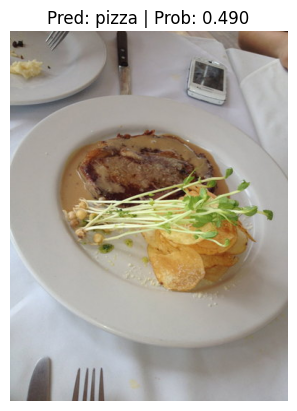

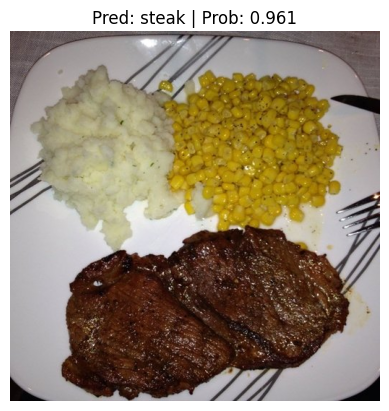

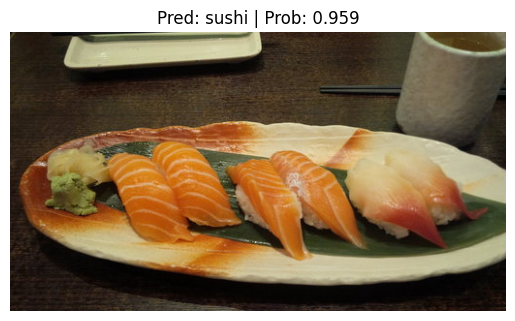

In [88]:
from going_modular.going_modular.predictions import pred_and_plot_image
import random
num_images_to_plot=3
test_image_path_list=list(Path(data_20_percent_path/'test').glob("*/*.jpg"))
test_image_path_sample=random.sample(test_image_path_list,k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,class_names=class_names,image_path=image_path,image_size=(224,224))

Custom image

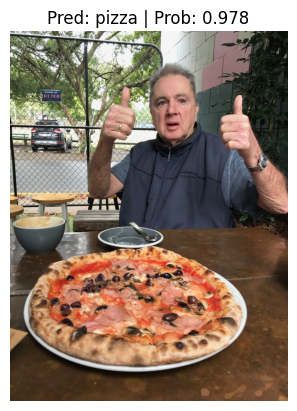

In [89]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)